In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import csv
import matplotlib.pyplot as plt

In [4]:
from scipy import stats

In [5]:
import math
import numpy as np

In [6]:
df_ON_OF = pd.read_csv("ON_OF.txt", sep='\t')

In [7]:
df_YN_ON = pd.read_csv("YN_ON.txt", sep='\t')

In [8]:
df_YF_OF = pd.read_csv("YF_OF.txt", sep='\t')

In [9]:
df_YN_YF = pd.read_csv("YN_YF.txt", sep='\t')

In [10]:
df_ON = df_ON_OF[[19,4,6,7,8,9]];

In [11]:
df_OF = df_ON_OF[[19,4,10,11,12,13]]

In [12]:
df_YN = df_YN_ON[[19,4,6,7,8,9]]

In [13]:
df_YF = df_YN_YF[[19,4,10,11,12,13]]

In [14]:
def drop_dup(d):
    d = d.drop_duplicates(subset='gene', keep='first')
    return d

def merge(d1, d2):
    return pd.merge(d1, d2, how='outer', on=['gene','width'])

def merge2(d1, d2):
    return pd.merge(d1, d2, how='outer', on='gene')

In [15]:
dft = merge(df_ON, df_OF)

In [16]:
dft = merge(dft, df_YN)

In [17]:
dft = merge(dft, df_YF)

In [18]:
dft = drop_dup(dft)

In [19]:
dft.dropna(thresh=(2), axis=0);

In [20]:
dft = dft[pd.notnull(dft).all(axis=1)]

In [21]:
df = dft

In [22]:
state_dict = {'AT2.young.flu.20150416': 'YF', 'AT2.old.naive.20150416': 'ON', 
                 'AT2.old.flu.20150416': 'OF', 'AT2.young.naive.20150416': 'YN'}

In [23]:
def rename_cols(df, state_dict):
    cols = df.columns
    temp_cols = list(cols)
    #print temp_cols
    for c in range(len(cols)):
        state_name = cols[c][:-2]
        #sample_num = cols[c][-2:]
        total_name = cols[c]
        #print state_name
        if state_name in state_dict:
            new_state_name = state_dict[state_name]
            new_col = total_name.replace(state_name, new_state_name)
            temp_cols[c] = new_col
            #print abb_pair_dict[state_name]
    df.columns = temp_cols
    #print temp_cols
    return df
        
    

In [24]:
df = rename_cols(df, state_dict)

In [25]:
len(df)

14285

In [26]:
def df_to_names(df):
    
    name_dict = {}
        
    for i in range(2,len(df.columns)):
        name = df.columns[i][:-2]
        if name in name_dict:
            name_dict[name].append(i)
        else:
            name_dict[name] = [i]
            
    return name_dict

In [27]:
name_dict = df_to_names(df)

In [28]:
def unique(a, b):
    return list([a[i] for i in range(1,len(a)) if a[i] not in b])
dww
def union(a, b):
    return list(set(a) | set(b))
def intersect3(a, b, c):
    return list(set(a) & set(b) & set(c))

def unique3(a, b, c, index):
    uniques = [0 for i in range(3)]
    uniques[0] = list([a[i] for i in range(1,len(a)) if a[i] not in b and a[i] not in c])
    uniques[1] = list([b[i] for i in range(1,len(b)) if b[i] not in a and b[i] not in c])
    uniques[2] = list([c[i] for i in range(1,len(c)) if c[i] not in a and c[i] not in b])
    return uniques[index]


In [29]:
def t_stat(df, names):
    
    ### Df has samples only, no gene
    #print df
    #names = df_to_names(df)
    #print "t-stat names", names #names[0], name_dict[names[0]]
    n_samples1 = len(name_dict[names[0]])
    n_samples2 = len(name_dict[names[1]])
    
    index1 = 1
    index2 = index1 + n_samples1
    
    width = df['width']
    #print "nsamps", n_samples1, n_samples2
    indices1 = [index1 + i for i in range(n_samples1)]
    indices2 = [index2 + i for i in range(n_samples2)]
    
    values1 = [df[df.columns[i]] for i in indices1]
    values2 = [df[df.columns[i]] for i in indices2]
    
    mean1 = sum(values1)/n_samples1
    mean2 = sum(values2)/n_samples2
    
    var1_num = [(values1[i] - mean1)**2 for i in range(n_samples1)]
    var2_num = [(values2[i] - mean2)**2 for i in range(n_samples2)]
    
    var1 = sum(var1_num)/(n_samples1 - 1)
    var2 = sum(var2_num)/(n_samples2 - 1)
    
    t_stat = (mean1 - mean2) / (var1/n_samples1 + var2/n_samples2)**0.5
    pval = stats.t.sf(np.abs(t_stat), n_samples1-1)*2 
    
    logfc = np.log2(mean2/mean1)
    
    diff = (mean2 - mean1) * width
    diff2 = (mean2 - mean1)
    
    return [pval, logfc, diff, mean1, diff2]

In [30]:
### Create new temp dataframe with cols ['samp1a','samp1b','samp2a','samp2b','gene']
### Add cols for logfc, pval
def names_to_df(names):
       
    # For first name    
    #print "names to df", names
    indices = list(name_dict[names[0]])
    l = len(indices)
    indices.insert(0,1)
    indices.insert(0,0)
    #print indices
    df_temp1 = df.ix[:,indices]
    #print df_temp1
    
    # For second name
    indices = list(name_dict[names[1]])
    l = len(indices)
    indices.insert(0,1)
    indices.insert(0,0)
    df_temp2 = df.ix[:,indices]
    
    dft = pd.merge(df_temp1, df_temp2, how='outer', on=['gene','width']);
    
    dft = dft.ix[1:];
    dft_float = dft.ix[:,1:].astype('float');
    dft_float = dft_float[dft_float > 0];

    #print dft_float
    dft['pval'], dft['logfc'], dft['diff'], dft['mean'], dft['diff_only'] = t_stat(dft_float, names)

    return dft
    #dft = merge(dft)

In [31]:
pairs_rel = [['YN','ON'],['YN','YF'],['ON','OF']]

In [36]:
def reset_pairs(df):
    
    name_dict = df_to_names(df)
    names = name_dict.keys()
    n_names = len(names)
    pairs = [[[names[i], names[j]] for i in range(n_names) if i != j] for j in range(n_names)]
    pairs = [pair for sublist in pairs for pair in sublist]
    return pairs

pairs = reset_pairs(df)

In [37]:
name_dict

{'OF': [6, 7, 8, 9],
 'ON': [2, 3, 4, 5],
 'YF': [14, 15, 16, 17],
 'YN': [10, 11, 12, 13]}

In [38]:
def filter_df(df, pcut = 0.05, fcut = 0.15, dcut = 25, mcut = 5):
    
    ### Filter all by pvalue
    df = df[df['pval'] < pcut]
    
    ## Highly upregulated
    df1 = df[df['diff'] > dcut]
    
    ## Highly downregulated
    df2 = df[df['diff'] < -dcut]
    
    ## Weakly upregulated
    df3 = df[df['diff'] < dcut]
    df3 = df3[df3['diff'] > 0]
    
    ## Weakly downregulated
    df4 = df[df['diff'] > -fcut]
    df4 = df4[df4['diff'] < 0]
    
    return [df1, df2, df3, df4]
        

In [39]:
def filter_grps(df, pcut = 0.05, fcut = 0, dcut = 0, mcut = 0):
    
    ### Filter all by pvalue
    df = df[df['pval'] < pcut]
    
    ## Highly upregulated
    df1 = df[df['diff'] > dcut]
    df1 = df1[df1['mean'] > mcut]
    df1 = df1[df1['logfc'] > fcut]
    
    ## Highly downregulated
    df2 = df[df['diff'] < dcut]
    df2 = df2[df2['mean'] > mcut]
    df2 = df2[df2['logfc'] < -fcut]

    return [df1, df2]
        

In [40]:
def grp_stats(group):
    
    mean_diff = round(np.mean(group['diff']),0)
    diff_low = round(np.mean(group['diff_only']),2)
    mean_val = round(np.mean(group['mean']),2)
    tot = mean_diff*len(group)
    return [len(group), diff_low, tot/1000000, mean_val]


In [55]:
#n_groups = 2
#for p1 in range(1,2):#len(pairs_rel)):

def common_stats(pairs):
    
    pair1 = pairs[0]
    print pair1
    df1 = names_to_df(pair1)
    df1_groups = filter_grps(df1)
    df1_genes = [group['gene'] for group in df1_groups]
    
    pair2 = pairs[1]
    print pair2
    df2 = names_to_df(pair2)
    df2_groups = filter_grps(df2)
    df2_genes = [group['gene'] for group in df2_groups]
        
    common_genes = [pd.DataFrame(intersect(df1_genes[i], df2_genes[i])) for i in range(n_groups)]
    #return df1_genes[0], df2_genes[0]
    #break
    unique_genes1 = [pd.DataFrame(unique(list(df1_genes[i]), list(df2_genes[i]))) for i in range(n_groups)]
    unique_genes2 = [pd.DataFrame(unique(list(df2_genes[i]), list(df1_genes[i]))) for i in range(n_groups)]
    
    for i in range(n_groups):
        common_genes[i].columns = ['gene']
        unique_genes1[i].columns = ['gene']
        unique_genes2[i].columns = ['gene']
    
    upgenes1 = unique(list(df1_genes[0]), list(df2_genes[0]))
    upgenes2 = unique(list(df2_genes[0]), list(df1_genes[0]))
    print "# in common", [len(common_genes[i]) for i in range(n_groups)]
    print "# unique in 1", [len(unique_genes1[i]) for i in range(n_groups)]
    print "# in group1", [len(genes) for genes in df1_genes]
        #print common_genes[0]
        ## Of the common genes, which are in first pair
        #print df1_groups[0]
    df1_common = [pd.merge(common_genes[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_common = [pd.merge(common_genes[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    #@df1[~ (df1_groups[0].gene.isin(df1_common.id1) & df1.id2.isin(df2.id2))]
    
    df1_unique = [pd.merge(unique_genes1[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_unique = [pd.merge(unique_genes2[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    dfs_uniq = [df1_unique, df2_unique]
    dfs_comm = [df1_common, df2_common]
    dfs_tots = [df1_groups, df2_groups]
    #dfup_comm = df1_common[0]
    #ne = (df1 != df2).any(1)
        #print "In common with pair 1"
        
        ## In
    d_graph = []
    for i in range(len(df1_groups)):
        
        if i==0: print "UPREG"
        else: print "DOWN REG"
        
        print "FIRST GROUP"
        print "Total"
        
        print grp_stats(df1_groups[i])

        print "Common"
        print grp_stats(df1_common[i])
        
        comm_1 = grp_stats(df1_common[i])[2]
        
        print "Unique"
        print grp_stats(df1_unique[i])
        
        uniq_1 = grp_stats(df1_unique[i])[2]

        d1 = [comm_1, uniq_1]
        d_graph.append(d1)
        
        print "Second Group"
        print "Total"
        print grp_stats(df2_groups[i])
        
        print "Common"
        comm_2 = grp_stats(df2_common[i])[2]
        print grp_stats(df2_common[i])
        
        print "Unique"
        uniq_2 = grp_stats(df2_unique[i])[2]
        print grp_stats(df2_unique[i])
        
        d2 = [comm_2, uniq_2]
        d_graph.append(d2)
        print '\n'
    
    return dfs_uniq, dfs_comm, dfs_tots

  

In [54]:
#n_groups = 2
#for p1 in range(1,2):#len(pairs_rel)):


def get_genes(pairs, gtype = 'unique', updn = 'dn'):
    
    pair1 = pairs[0]
    print pair1
    df1 = names_to_df(pair1)
    df1_groups = filter_grps(df1)
    df1_genes = [group['gene'] for group in df1_groups]
    
    pair2 = pairs[1]
    print pair2
    df2 = names_to_df(pair2)
    df2_groups = filter_grps(df2)
    df2_genes = [group['gene'] for group in df2_groups]
        
    common_genes = [pd.DataFrame(intersect(df1_genes[i], df2_genes[i])) for i in range(n_groups)]
    unique_genes1 = [pd.DataFrame(unique(list(df1_genes[i]), list(df2_genes[i]))) for i in range(n_groups)]
    unique_genes2 = [pd.DataFrame(unique(list(df2_genes[i]), list(df1_genes[i]))) for i in range(n_groups)]
    
    if gtype = 'unique'
    
    for i in range(n_groups):
        common_genes[i].columns = ['gene']
        unique_genes1[i].columns = ['gene']
        unique_genes2[i].columns = ['gene']
    
    upgenes1 = unique(list(df1_genes[0]), list(df2_genes[0]))
    upgenes2 = unique(list(df2_genes[0]), list(df1_genes[0]))
    print "# in common", [len(common_genes[i]) for i in range(n_groups)]
    print "# unique in 1", [len(unique_genes1[i]) for i in range(n_groups)]
    print "# in group1", [len(genes) for genes in df1_genes]
        #print common_genes[0]
        ## Of the common genes, which are in first pair
        #print df1_groups[0]
    df1_common = [pd.merge(common_genes[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_common = [pd.merge(common_genes[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    #@df1[~ (df1_groups[0].gene.isin(df1_common.id1) & df1.id2.isin(df2.id2))]
    
    df1_unique = [pd.merge(unique_genes1[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_unique = [pd.merge(unique_genes2[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    dfs_uniq = [df1_unique, df2_unique]
    dfs_comm = [df1_common, df2_common]
    dfs_tots = [df1_groups, df2_groups]
    #dfup_comm = df1_common[0]
    #ne = (df1 != df2).any(1)
        #print "In common with pair 1"
        
        ## In
    d_graph = []
    for i in range(len(df1_groups)):
        
        if i==0: print "UPREG"
        else: print "DOWN REG"
        
        print "FIRST GROUP"
        print "Total"
        
        print grp_stats(df1_groups[i])

        print "Common"
        print grp_stats(df1_common[i])
        
        comm_1 = grp_stats(df1_common[i])[2]
        
        print "Unique"
        print grp_stats(df1_unique[i])
        
        uniq_1 = grp_stats(df1_unique[i])[2]

        d1 = [comm_1, uniq_1]
        d_graph.append(d1)
        
        print "Second Group"
        print "Total"
        print grp_stats(df2_groups[i])
        
        print "Common"
        comm_2 = grp_stats(df2_common[i])[2]
        print grp_stats(df2_common[i])
        
        print "Unique"
        uniq_2 = grp_stats(df2_unique[i])[2]
        print grp_stats(df2_unique[i])
        
        d2 = [comm_2, uniq_2]
        d_graph.append(d2)
        print '\n'
    
    return d_graph #dfs_uniq, dfs_comm, dfs_tots

  

SyntaxError: invalid syntax (<ipython-input-54-3a8cc7b831cd>, line 23)

In [51]:
common_stats(pairs_rel[1:])

['YN', 'YF']
['ON', 'OF']
# in common [681, 463]
# unique in 1 [460, 459]
# in group1 [1141, 923]
UPREG
FIRST GROUP
Total
[1141, 9.21, 75.761259, 7.73]
Common
[681, 14.35, 68.205555, 10.32]
Unique
[460, 1.58, 7.55596, 3.9]
Second Group
Total
[1202, 10.73, 84.148414, 10.37]
Common
[681, 15.96, 73.165959, 11.37]
Unique
[521, 3.9, 10.982159, 9.06]


DOWN REG
FIRST GROUP
Total
[923, -9.7, -46.144462, 43.3]
Common
[463, -17.63, -37.402066, 79.33]
Unique
[459, -1.73, -8.718246, 7.03]
Second Group
Total
[1373, -7.79, -56.887509, 32.06]
Common
[463, -16.5, -34.020314, 76.35]
Unique
[909, -3.37, -22.862259, 9.54]




[[68.205555, 7.55596],
 [73.165959, 10.982159],
 [-37.402066, -8.718246],
 [-34.020314, -22.862259]]

In [45]:
n_groups = 2
#for p1 in range(1,2):#len(pairs_rel)):

out1 = open('YN_YF_unique_up','w')

def common_stats_graph(pairs):
    
    pair1 = pairs[0]
    print pair1
    df1 = names_to_df(pair1)
    df1_groups = filter_grps(df1, fcut=0.1)
    df1_genes = [group['gene'] for group in df1_groups]
    
    pair2 = pairs[1]
    print pair2
    df2 = names_to_df(pair2)
    df2_groups = filter_grps(df2, fcut=0.1)
    df2_genes = [group['gene'] for group in df2_groups]
    
    common_genes = [pd.DataFrame(intersect(df1_genes[i], df2_genes[i])) for i in range(n_groups)]
    #return df1_genes[0], df2_genes[0]
    #break
    unique_genes1 = [pd.DataFrame(unique(list(df1_genes[i]), list(df2_genes[i]))) for i in range(n_groups)]
    unique_genes2 = [pd.DataFrame(unique(list(df2_genes[i]), list(df1_genes[i]))) for i in range(n_groups)]
    
    for i in range(n_groups):
        common_genes[i].columns = ['gene']
        unique_genes1[i].columns = ['gene']
        unique_genes2[i].columns = ['gene']
    
    upgenes1 = unique(list(df1_genes[0]), list(df2_genes[0]))
    upgenes2 = unique(list(df2_genes[0]), list(df1_genes[0]))
    print "# in common", [len(common_genes[i]) for i in range(n_groups)]
    print "# unique in 1", [len(unique_genes1[i]) for i in range(n_groups)]
    print "# in group1", [len(genes) for genes in df1_genes]
        #print common_genes[0]
        ## Of the common genes, which are in first pair
        #print df1_groups[0]
    df1_common = [pd.merge(common_genes[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_common = [pd.merge(common_genes[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    #@df1[~ (df1_groups[0].gene.isin(df1_common.id1) & df1.id2.isin(df2.id2))]
    
    df1_unique = [pd.merge(unique_genes1[i], df1_groups[i], how='left') for i in range(n_groups)]
    df2_unique = [pd.merge(unique_genes2[i], df2_groups[i], how='left') for i in range(n_groups)]
    
    dfs_uniq = [df1_unique, df2_unique]
    dfs_comm = [df1_common, df2_common]
    dfs_tots = [df1_groups, df2_groups]
    #dfup_comm = df1_common[0]
    #ne = (df1 != df2).any(1)
        #print "In common with pair 1"
        
        ## In
    p1_graph = []
    p2_graph = []
    p_graph = []
    for i in range(len(df1_groups)):
            
        if i==0: card = 1
        else: card = -1
                
        comm_1 = grp_stats(df1_common[i])[2]
 
        uniq_1 = grp_stats(df1_unique[i])[2]

        d1 = [card*comm_1, card*uniq_1]
        
        p_graph.append(d1)
        
        comm_2 = grp_stats(df2_common[i])[2]
  
        uniq_2 = grp_stats(df2_unique[i])[2]

        
        d2 = [card*comm_2, card*uniq_2]
        p_graph.append(d2)
    
    pd.DataFrame(p_graph, columns=['a', 'b']).plot(kind='bar',stacked=True, title = pairs)
    #plt.axhline(0, color='k')
    #return p_graph #dfs_uniq, dfs_comm, dfs_tots

  

['YN', 'ON']
['ON', 'OF']
# in common [85, 70]
# unique in 1 [491, 503]
# in group1 [577, 574]


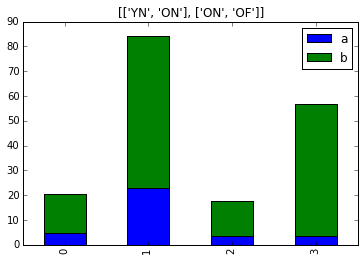

In [49]:
d_graph_age0 = common_stats_graph([['YN','ON'],['ON','OF']])

In [47]:
def uniq_ratio(lst):
    return [lst[i][1]/lst[i][0] for i in range(len(lst))]

['YN', 'YF']
['ON', 'OF']
# in common [681, 463]
# unique in 1 [459, 459]
# in group1 [1140, 923]


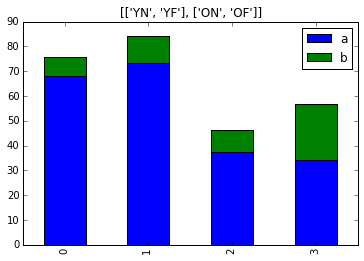

In [48]:
d_graph_flu = common_stats_graph([['YN','YF'],['ON','OF']])

In [ ]:
pd.DataFrame(d_graph_flu).plot(kind='bar',stacked=True)

In [ ]:
pd.DataFrame(uniq_ratio(d_graph)).plot(kind='bar',stacked=True)

In [ ]:
dfY_up = dfsuniq[0][0].ix[:,[0,10,11]]
dfY_dn = dfsuniq[0][1].ix[:,[0,10,11]]
dfO_up = dfsuniq[1][0].ix[:,[0,10,11]]
dfO_dn = dfsuniq[1][1].ix[:,[0,10,11]]

In [ ]:
df2 = pd.DataFrame(np.random.rand(4, 2), columns=['a', 'b'])

In [ ]:
dfY_up_comm = dfs_comm[0][0].ix[:,[0,10,11]]
dfY_dn_comm = dfs_comm[0][1].ix[:,[0,10,11]]
dfO_up_comm = dfs_comm[1][0].ix[:,[0,10,11]]
dfO_dn_comm = dfs_comm[1][1].ix[:,[0,10,11]]

In [ ]:
dfY_up_comm.to_csv('dfY_up_comm.txt',sep='\t', index=False)
dfY_dn_comm.to_csv('dfY_dn_comm.txt',sep='\t', index=False)
dfO_up_comm.to_csv('dfO_up_comm.txt',sep='\t', index=False)
dfO_dn_comm.to_csv('dfO_dn_comm.txt',sep='\t', index=False)

In [ ]:
dfY_up.to_csv('dfY_up.txt',sep='\t', index=False)
dfY_dn.to_csv('dfY_dn.txt',sep='\t', index=False)
dfO_up.to_csv('dfO_up.txt',sep='\t', index=False)
dfO_dn.to_csv('dfO_dn.txt',sep='\t', index=False)

In [56]:
dfs_comm, dfs_uniq, dfsgrps = common_stats([['YN','YF'],['ON','OF']])
## Commonly regulated genes used in aging and old flu are 50% higher in flu.
## CRGs comprise 20% in upreg, but only 5% in ON_OF downerg
## Much more downreg URGs 

['YN', 'YF']
['ON', 'OF']
# in common [681, 463]
# unique in 1 [460, 459]
# in group1 [1141, 923]
UPREG
FIRST GROUP
Total
[1141, 9.21, 75.761259, 7.73]
Common
[681, 14.35, 68.205555, 10.32]
Unique
[460, 1.58, 7.55596, 3.9]
Second Group
Total
[1202, 10.73, 84.148414, 10.37]
Common
[681, 15.96, 73.165959, 11.37]
Unique
[521, 3.9, 10.982159, 9.06]


DOWN REG
FIRST GROUP
Total
[923, -9.7, -46.144462, 43.3]
Common
[463, -17.63, -37.402066, 79.33]
Unique
[459, -1.73, -8.718246, 7.03]
Second Group
Total
[1373, -7.79, -56.887509, 32.06]
Common
[463, -16.5, -34.020314, 76.35]
Unique
[909, -3.37, -22.862259, 9.54]




In [60]:
dfs_uniq[0]

[               gene   width        YN.1        YN.2        YN.3        YN.4  \
 0           Gm20536    6355  128.859799  157.366727  136.554340  134.476444   
 1              Nub1   24741    2.994678    2.776934    2.644356    2.828954   
 2             Cmpk2   10632    2.228858    1.120961    0.879071    1.493637   
 3             Nampt   33035    1.861444    1.220254    1.556064    1.477746   
 4               Ehf   39846    3.176860    3.492468    3.107923    3.173583   
 5     3010026O09Rik   25672    0.128530    0.177505    0.291252    0.332204   
 6              Tbl3    9712    3.459232    3.717537    3.753143    3.028011   
 7           Gm13571   33047    0.099846    0.116678    0.084845    0.071191   
 8           Gm26522    4743   18.277428   20.915103   14.483495   16.120792   
 9              Bak1    9200    2.021502    1.409745    1.473056    1.438437   
 10            H2-M3    4265    0.843981    1.232818    0.766987    1.034281   
 11              Sp5    2807    7.907873

In [ ]:
n_grps = 2
#for p1 in range(1,2):#len(pairs_rel)):

def common_stats3():
    
    pairs = [['YN', 'ON'], ['ON','OF'],['YN','YF']]
    n_pairs = len(pairs)
    dfs = [names_to_df(pair) for pair in pairs]
    dfgrps = [filter_grps(dft) for dft in dfs]
    dfgenes = [[group['gene'] for group in grps] for grps in dfgrps]
    
    ## returns 1 set per group
    common_genes = [pd.DataFrame(intersect3(dfgenes[0][i], dfgenes[1][i], dfgenes[2][i])) for i in range(n_groups)]
    
    ## returns list of 3 sets per group
    unique_genes = [[pd.DataFrame(unique3(list(dfgenes[0][i]), list(dfgenes[1][i]), list(dfgenes[2][i]), j)) \
                    for j in range(n_pairs)] for i in range(n_grps)]
                    #for i in range(n_groups)]
    #print len(unique_genes)
    for i in range(n_grps):
        common_genes[i].columns = ['gene']
        for j in range(n_pairs):
            unique_genes[i][j].columns = ['gene']
    
    dfs_comm = [[pd.merge(common_genes[i], dfgrps[j][i], how='left') for i in range(n_grps)] for j in range(n_pairs)]
    dfs_uniq = [[pd.merge(unique_genes[i][j], dfgrps[j][i], how='left') for i in range(n_grps)] for j in range(n_pairs)]

    for i in range(n_grps):
        
        print '\n'
        if i==0: print "UPREG"
        else: print "DOWN REG"
        print '\n'
        
        for j in range(n_pairs):
            
            print '\n'
            print "PAIR", pairs[j]
        
            print "Total"
            print grp_stats(dfgrps[j][i])
            print "Common"
            print grp_stats(dfs_comm[j][i])
            print "Unique"
            print grp_stats(dfs_uniq[j][i])

    return dfs_comm, dfs_uniq, dfsgrps


In [ ]:
dfs_comm[0][0][]

In [ ]:
dfs_comm, dfs_uniq, dfsgrps = common_stats3()
### common genes upgregulated used same amount by Old illness and Young illness

In [ ]:
dfs_comm[2][1].sort('diff')

In [ ]:
upcomm = common_stats([['YN','ON'],['ON','OF']]);
### Common are general purpose upreg/downreg??? between aging and flu

In [ ]:
### Needs dataframe with cols ('gene', 'logfc', 'pval')

def filter_genes(df, pcut = 0.05, fcut = 1.4):
    
    df_pcut = df[df['pval'] < pcut]
    
    df_fc_up = df_pcut[df_pcut['logfc'] > fcut]
    
    df_fc_dn = df_pcut[df_pcut['logfc'] < -fcut]
    
    df_pv_up = df_pcut[df_pcut['logfc'] < fcut]
    df_pv_up = df_pv_up[df_pv_up['logfc'] > 0]
    
    df_pv_dn = df_pcut[df_pcut['logfc'] < 0]
    df_pv_dn = df_pv_dn[df_pv_dn['logfc'] > -fcut]

    fc_up_genes = df_fc_up['gene']
    fc_dn_genes = df_fc_dn['gene']
    pv_up_genes = df_pv_up['gene']
    pv_dn_genes = df_pv_dn['gene']
    
    #n_up_fc = sum(df_fc_up.ix[:,'up'])
    #n_dn_fc = sum(df_fc_dn.ix[:,'dn'])
    #n_up_pv = sum(df_pv_up.ix[:,'up'])
    #n_dn_pv = sum(df_pv_dn.ix[:,'dn'])

    return [fc_up_genes, fc_dn_genes, pv_up_genes, pv_dn_genes]


In [ ]:
def get_counts(names):
    
    dft = names_to_df(names)
    dft_genes = filter_genes(dft)
    dft_counts = [len(genes) for genes in dft_genes]
    return dft_counts
    

In [ ]:
def pair_pair_counts(name_pairs):
    
    dft1 = names_to_df(name_pairs[0])
    dft2 = names_to_df(name_pairs[1])
    
    dft1_genes = filter_genes(dft1)
    dft2_genes = filter_genes(dft2)
    
    common_genes = [intersect(dft1_genes[i], dft2_genes[i]) for i in range(len(dft1_genes))]
    common_counts = [len(genes) for genes in common_genes]
    return common_counts
    

In [ ]:
def all_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs2 = list(pairs)
    
    for p in range(len(pairs)):
        #pair in pairs:
        counts = get_counts(pairs2[p])
        pairs2[p].append(counts)
        
    return pairs2

In [ ]:
def common_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, pair2],[counts]]
            data.append(data12)
            
        
    return data

In [ ]:
def common_ratio(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, pair2],float(counts[0])/float(counts[1])]
            data.append(data12)
            
        
    return data

In [ ]:
def uncommon_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        counts1 = get_counts(pair1)
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts2 = get_counts(pair2)
            counts_pair = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, counts1, pair2, counts2],[counts_pair]]
            data.append(data12)
            
    return data